In [1]:
import csv
import numpy as np
import pandas as pd
from tabulate import tabulate
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
%cd /storage2/mwildi/CBS2

/storage2/mwildi/CBS2


In [2]:
#Plots data inside data_per_model
def plotter(data_per_model, main_title, legends, x_ticks, x_description, y_description, savepath):
    assert(len(legends)==data_per_model.shape[0])
    assert(len(x_ticks)==data_per_model.shape[1])

    metrics = pd.DataFrame(np.array([data_per_model[:,i] for i in range(len(x_ticks))]), columns=legends)
    ax = metrics.plot(kind='bar', figsize=(7, 4), legend=True
                      , fontsize=16, zorder=3)
    ax.set_xlabel(x_description)
    x = np.arange(len(x_ticks))
    ax.set_xticks(x)
    ax.set_xticklabels(x_ticks, fontsize=16, rotation='horizontal')
    ax.set_ylabel(y_description, fontsize=16)
    ax.grid(axis='y', zorder=0)
    plt.title(main_title, fontsize=20, weight='bold')
    plt.savefig(savepath)

In [3]:
#####################################################################################
# Parsing code adapted from World on Rails scripts/view_nocrash_results
#####################################################################################

def parse_results(path):
    
    TOWNS = ['Town01', 'Town02']
    TRAFFICS = ['empty', 'regular', 'dense']
    WEATHERS = {
        1: 'train', 3: 'train', 6: 'train', 8: 'train',
        10: 'test', 14: 'test',
    }
    #METRICS = ['sr', 'rc', 'l', 'nb', 'nc', 'ncv', 'ncw', 'rcwc']
    METRICS = ['Success', 'Route Completion', 'Lights Ran per hour', 'No Block', 'No Collision', 'No Collision Vehicle', 'No Collision Walker', 'No Collision Obstacle', 'RC When Collided', 'In Lane']

    finished = defaultdict(lambda: [])

    with open(path+'.csv', 'r') as file:
        log = csv.DictReader(file)
        for row in log:
            finished[(
                row['town'],
                int(row['traffic']),
                WEATHERS[int(row['weather'])],
            )].append((
                float(row['route_completion']),
                int(row['lights_ran']),
                float(row['duration']),
                float(row['outside_lane']),
                str(row['collision']),
                str(row['collision_vehicle']),
                str(row['collision_walker']),
                str(row['in_route']),
                str(row['blocked'])
            ))

    all_stats=dict()
    
    for town, weather_set in product(TOWNS, set(WEATHERS.values())):

        all_stats[town+weather_set] = {}
        
        for metric in METRICS:
            stat= ['N/A']*len(TRAFFICS)

            for traffic_idx, traffic in enumerate(TRAFFICS):
                runs = finished[town,TRAFFICS.index(traffic),weather_set]

                if len(runs) > 0:
                    route_completion, lights_ran, duration, outside_lane, collision, collision_vehicle, collision_walker, in_route, blocked = zip(*runs)
                    mean_lights_ran = np.array(lights_ran)/np.array(duration)*3600

                    if metric == 'Success': # Success Rate
                        stat[traffic_idx] = np.round(100*np.mean(np.array(route_completion)==100), 2)
                    elif metric == 'Route Completion': # Route Completion
                        stat[traffic_idx] = np.round(np.mean(route_completion), 2)
                    elif metric == 'Lights Ran per hour': # Lights Ran per hour
                        stat[traffic_idx] = np.round(np.mean(mean_lights_ran), 2)
                    elif metric == 'No Block': # No block
                        stat[traffic_idx] = np.round(100*blocked.count('SUCCESS')/len(blocked), 2)
                    elif metric == 'No Collision': # No Collision
                        stat[traffic_idx] = round(100*collision.count('SUCCESS')/len(collision), 2)
                    elif metric == 'No Collision Vehicle': # No Collision vehicle
                        stat[traffic_idx] = np.round(100*collision_vehicle.count('SUCCESS')/len(collision_vehicle), 2)
                    elif metric == 'No Collision Walker': # No Collision walker
                        stat[traffic_idx] = np.round(100*collision_walker.count('SUCCESS')/len(collision_walker), 2)
                    elif metric == 'No Collision Obstacle': # In Lane
                        stat[traffic_idx] = np.round(100 - 100*(collision.count('FAILURE')/len(collision) - 
                                                               collision_vehicle.count('FAILURE')/len(collision_vehicle) -
                                                               collision_walker.count('FAILURE')/len(collision_walker)), 2)
                    elif metric == 'RC When Collided': # Route completion when collided
                        collided = [True if x=='FAILURE' else False for x in collision]
                        stat[traffic_idx] = np.round(np.mean(np.array(route_completion)[collided]), 2)
                    elif metric == 'In Lane': # In Lane
                        stat[traffic_idx] = np.round(100 - np.mean(outside_lane), 2)
                        

                all_stats[town+weather_set][metric] = stat
                
    return all_stats

In [4]:
original=parse_results('results/final/l2_original')
ppm=parse_results('results/final/l2_ppm')
fpn=parse_results('results/final/l2_fpn')

In [38]:
#['Success', 'Route Completion', 'Lights Ran per hour', 'No Block', 'No Collision', 'No Collision Vehicle', 'No Collision Walker', 'No Collision Obstacle', 'RC When Collided', 'In Lane']
main_title = 'Directional command at intersection'
y_description = 'Y label'
savepath = 'Notebooks/plots/dataset/dataset_cmd.png'

plot_metric='Lights Ran per hour'
plot_metric='No Block'
#plot_metric='Route Completion'
#plot_metric='No Collision'
plot_metric='Lights Ran per hour'
plot_type=0
one_graph = True

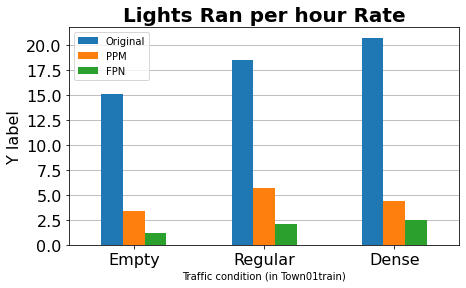

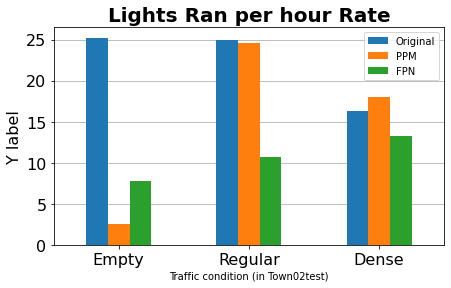

In [39]:
legends = ['Original', 'PPM', 'FPN']
#CONFIGS = ['Town01train', 'Town01test', 'Town02train', 'Town02test']
CONFIGS = ['Town01train', 'Town02test']
TRAFFICS = ['empty', 'regular', 'dense']
#Comparison according to traffic
if plot_type == 0:
    for plot_config in CONFIGS:
        x_ticks = ['Empty', 'Regular', 'Dense']
        x_description = 'Traffic condition (in '+plot_config+')'
        data_original = original[plot_config][plot_metric]
        data_ppm = ppm[plot_config][plot_metric]
        data_fpn = fpn[plot_config][plot_metric]
        data_per_model = np.vstack((data_original, data_ppm, data_fpn))
        plotter(data_per_model, plot_metric+' Rate', legends, x_ticks, x_description, y_description, savepath)
#Comparison according to train/test
else:
    one_plot_data_per_model = np.zeros((len(legends), len(CONFIGS)))
    for plot_traffic in TRAFFICS:
        x_ticks = CONFIGS
        x_description = 'Town-weather configuration (in '+plot_traffic+' traffic)'
        data_original = [original[config][plot_metric][TRAFFICS.index(plot_traffic)] for config in CONFIGS]
        data_ppm = [ppm[config][plot_metric][TRAFFICS.index(plot_traffic)] for config in CONFIGS]
        data_fpn = [fpn[config][plot_metric][TRAFFICS.index(plot_traffic)] for config in CONFIGS]  
        data_per_model = np.vstack((data_original, data_ppm, data_fpn))
        one_plot_data_per_model = one_plot_data_per_model + data_per_model
        if not one_graph:
            print(data_per_model)
            plotter(data_per_model, plot_metric+' Rate', legends, x_ticks, x_description, y_description, savepath)
    if one_graph:
        one_plot_data_per_model/=len(TRAFFICS)
        x_description = 'Town-weather configuration (averaged over all traffic conditions)'
        plotter(one_plot_data_per_model, plot_metric+' Rate', legends, x_ticks, x_description, y_description, savepath)

In [30]:
fpn

{'Town01test': {'Success': [8.0, 20.0, 10.0],
  'Route Completion': [39.52, 48.23, 37.23],
  'Lights Ran per hour': [0.49, 1.47, 1.78],
  'No Block': [24.0, 42.0, 76.0],
  'No Collision': [96.0, 88.0, 40.0],
  'No Collision Vehicle': [100.0, 92.0, 48.0],
  'No Collision Walker': [100.0, 100.0, 94.0],
  'No Collision Obstacle': [96.0, 96.0, 98.0],
  'RC When Collided': [44.76, 58.14, 33.44],
  'In Lane': [98.75, 97.5, 97.86]},
 'Town01train': {'Success': [16.0, 27.0, 10.0],
  'Route Completion': [44.53, 53.24, 42.9],
  'Lights Ran per hour': [1.15, 2.12, 2.51],
  'No Block': [32.0, 52.0, 80.0],
  'No Collision': [94.0, 86.0, 35.0],
  'No Collision Vehicle': [100.0, 92.0, 41.0],
  'No Collision Walker': [100.0, 100.0, 100.0],
  'No Collision Obstacle': [94.0, 94.0, 94.0],
  'RC When Collided': [46.28, 46.33, 38.49],
  'In Lane': [91.86, 91.56, 91.88]},
 'Town02test': {'Success': [4.0, 8.0, 2.0],
  'Route Completion': [37.0, 47.61, 39.13],
  'Lights Ran per hour': [7.74, 10.7, 13.27],
  '